In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from optuna.trial import Trial
from sklearn.model_selection import KFold
import time, pickle, os


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (21, 9)
plt.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')

In [17]:
COLUMNS=[
    'manufacturer',
    'model',
    'vehicle_condition',
    'battery_capacity',
    'drivetrain',
    'mileage',
    'warranty_period',
    'accident_history',
    'year_of_manufacture',
]
SEED = 42

In [18]:
train = pd.read_csv('./data/train.csv')
train = train.drop(columns=['ID'])
train.columns = COLUMNS + ['y']
train.manufacturer = train.manufacturer.str.replace('사', '_corp')

test = pd.read_csv('./data/test.csv')
test = test.drop(columns=['ID'])
test.columns = COLUMNS
test_X = test
test_X.manufacturer = test_X.manufacturer.str.replace('사', '_corp')

In [4]:
if False:
    train.battery_capacity = pd.cut(train.battery_capacity, bins=10)
    # cut test battery capacity with the same bins as train
    test.battery_capacity = pd.cut(test.battery_capacity, bins=train.battery_capacity.cat.categories)
    train.battery_capacity = train.battery_capacity.astype(str)
    test.battery_capacity = test.battery_capacity.astype(str)
else:
    train['battery_capacity'] = train['battery_capacity'].fillna(0)
    test['battery_capacity'] = test['battery_capacity'].fillna(0)

In [5]:
pd.concat([train.nunique(), test.nunique()], axis=1)

,0,1
manufacturer,7,7.0
model,21,21.0
vehicle_condition,3,3.0
battery_capacity,195,93.0
drivetrain,3,3.0
mileage,6916,842.0
warranty_period,11,11.0
accident_history,2,2.0
year_of_manufacture,3,3.0
y,3950,NaN


In [6]:
group = [
    # 'manufacturer', 
    'model',
    # 'accident_history',
    'vehicle_condition',
]
pd.concat([train.groupby(group).size(), test.groupby(group).size()], axis=1).rename(columns={0: 'train', 1: 'test'})

train  test
model  vehicle_condition             
EV6    Brand New            369    42
ID4    Brand New            276    34
       Nearly New           169    13
       Pre-Owned            160    21
ION5   Brand New            170    18
       Nearly New            87     7
       Pre-Owned             96    15
ION6   Brand New            179    21
       Nearly New            88    15
       Pre-Owned            112     7
IONIQ  Nearly New            66     8
       Pre-Owned             74     8
KNE    Brand New            163    16
       Nearly New           108    15
       Pre-Owned             94    10
M3     Brand New            135    13
       Nearly New            73     9
       Pre-Owned             71     9
MS     Brand New            126    15
       Nearly New            79     8
       Pre-Owned             72     8
MX     Brand New            126    18
       Nearly New            62     4
       Pre-Owned             76     8
MY     Brand New            133    17
       Nearly New            76     8
       Pre-Owned             80     8
Niro   Brand New             75    11
       Nearly New           157    17
       Pre-Owned            166    17
Q4eT   Brand New            175    15
       Nearly New           114    13
       Pre-Owned             89    15
RSeTGT Brand New            180    21
       Nearly New           108    10
       Pre-Owned             97    12
Soul   Brand New             81    15
       Nearly New           160    16
       Pre-Owned            156    14
Tay    Brand New            168    14
       Nearly New            99    17
       Pre-Owned             94    10
TayCT  Brand New            149    15
       Nearly New            90    10
       Pre-Owned             96    13
TayGTS Brand New            173    15
       Nearly New            97     9
       Pre-Owned            105    18
eT     Brand New            174    16
       Nearly New           102    15
       Pre-Owned            103    12
i3     Brand New             73     8
       Nearly New           166    20
       Pre-Owned            149    16
i5     Brand New             88    13
       Nearly New           158    21
       Pre-Owned            168    12
iX     Brand New            367    41

In [7]:
group = [
    # 'manufacturer', 
    # 'model',
    # 'accident_history',
    # 'vehicle_condition',
    # 'accident_history',
    'model',
    'year_of_manufacture',
    # 'drivetrain',
]
pd.concat([train.groupby(group).size(), test.groupby(group).size()], axis=1).rename(columns={0: 'train', 1: 'test'})

train  test
model  year_of_manufacture             
EV6    0                      369  42.0
ID4    0                      528  62.0
       1                       37   3.0
       2                       40   3.0
ION5   0                      306  37.0
       1                       27   2.0
       2                       20   1.0
ION6   0                      331  36.0
       1                       25   3.0
       2                       23   4.0
IONIQ  0                       52   4.0
       1                       38   7.0
       2                       50   5.0
KNE    0                      304  33.0
       1                       27   5.0
       2                       34   3.0
M3     0                      244  26.0
       1                       20   4.0
       2                       15   1.0
MS     0                      232  28.0
       1                       22   1.0
       2                       23   2.0
MX     0                      231  27.0
       1                       16   1.0
       2                       17   2.0
MY     0                      248  32.0
       1                       20   NaN
       2                       21   1.0
Niro   0                      328  36.0
       1                       34   6.0
       2                       36   3.0
Q4eT   0                      315  37.0
       1                       29   3.0
       2                       34   3.0
RSeTGT 0                      335  38.0
       1                       24   3.0
       2                       26   2.0
Soul   0                      311  35.0
       1                       36   4.0
       2                       50   6.0
Tay    0                      313  34.0
       1                       27   4.0
       2                       21   3.0
TayCT  0                      284  33.0
       1                       23   2.0
       2                       28   3.0
TayGTS 0                      330  40.0
       1                       21   1.0
       2                       24   1.0
eT     0                      332  36.0
       1                       25   4.0
       2                       22   3.0
i3     0                      299  35.0
       1                       45   5.0
       2                       44   4.0
i5     0                      336  35.0
       1                       40   5.0
       2                       38   6.0
iX     0                      367  41.0

In [59]:
CONCATS = [
    'model', 
    # 'year_of_manufacture',
    # 'vehicle_condition', 
    # 'accident_history'
]
for col in CONCATS:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
train['_'.join(CONCATS)] = train[CONCATS].apply(lambda x: '_'.join(x), axis=1)
test['_'.join(CONCATS)] = test[CONCATS].apply(lambda x: '_'.join(x), axis=1)

train = train.drop(columns=CONCATS)
test = test.drop(columns=CONCATS)

In [8]:
DROPS = [
    'manufacturer', 
    # 'accident_history',
    # 'year_of_manufacture',
    # 'battery_capacity',
]

train = train.drop(DROPS, axis=1, errors='ignore')
test = test.drop(DROPS, axis=1, errors='ignore')

In [9]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
# y_scaler = StandardScaler()

# select numerical columns
x_scaler.fit(train[train.select_dtypes(include='number').columns.drop('y')])
train.loc[:, train.select_dtypes(include='number').columns.drop('y')] = x_scaler.transform(train[train.select_dtypes(include='number').columns.drop('y')])
# train.loc[:, 'y'] = y_scaler.fit_transform(train[['y']])
test.loc[:, test.select_dtypes(include='number').columns] = x_scaler.transform(test[test.select_dtypes(include='number').columns])

In [10]:
combined = pd.concat([train,test], axis=0, ignore_index=True)
FEATURES = combined.columns.drop("y")
CATS = []
HIGH_CARDINALITY = []

In [11]:
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")
for c in FEATURES:
    ftype = "numerical"
    if combined[c].dtype=="object":
        if combined[c].nunique()>2:
            CATS.append(c)
            combined[c] = combined[c].fillna("NAN")
            combined[c],_ = combined[c].factorize()
            combined[c] -= combined[c].min()
            ftype = "categorical"
        else:
            combined[c] = combined[c].factorize()[0]
            ftype = "boolean"
    if combined[c].dtype=="int64":
        combined[c] = combined[c]
    elif combined[c].dtype=="float64":
        combined[c] = combined[c]
        
    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=25: HIGH_CARDINALITY.append(c)
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

THE 8 BASIC FEATURES ARE:
model (categorical) with 21 unique values
vehicle_condition (categorical) with 3 unique values
battery_capacity (numerical) with 203 unique values
drivetrain (categorical) with 3 unique values
mileage (numerical) with 7633 unique values
warranty_period (numerical) with 11 unique values
accident_history (boolean) with 2 unique values
year_of_manufacture (numerical) with 3 unique values


In [12]:
from sklearn.preprocessing import OneHotEncoder
# to_onehot = list(set(CATS + INTS))
to_onehot = CATS
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories='auto')
one_hot_encoder.fit(train[to_onehot])

train_encoded = one_hot_encoder.transform(train[to_onehot])
test_encoded = one_hot_encoder.transform(test[to_onehot])

train = pd.concat([train, pd.DataFrame(train_encoded, columns=[f"ohe_{i}" for i in one_hot_encoder.get_feature_names_out()])], axis=1)
test = pd.concat([test, pd.DataFrame(test_encoded, columns=[f"ohe_{i}" for i in one_hot_encoder.get_feature_names_out()])], axis=1)

In [13]:
train

,model,vehicle_condition,battery_capacity,drivetrain,mileage,warranty_period,accident_history,year_of_manufacture,y,ohe_model_0,ohe_model_1,ohe_model_2,ohe_model_3,ohe_model_4,ohe_model_5,ohe_model_6,ohe_model_7,ohe_model_8,ohe_model_9,ohe_model_10,ohe_model_11,ohe_model_12,ohe_model_13,ohe_model_14,ohe_model_15,ohe_model_16,ohe_model_17,ohe_model_18,ohe_model_19,ohe_model_20,ohe_vehicle_condition_0,ohe_vehicle_condition_1,ohe_vehicle_condition_2,ohe_drivetrain_0,ohe_drivetrain_1,ohe_drivetrain_2
0,0,0,1.176470,0,-0.555177,-1.572333,0,3.122858,159.66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,0,0.329432,1,-0.617550,0.329331,0,-0.390885,28.01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,1,1.320746,0,-0.759541,0.646275,0,-0.390885,66.27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,0,-1.247658,0,-0.409508,-0.621501,0,-0.390885,99.16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,4,2,0.470751,0,2.426016,-1.255389,0,-0.390885,62.02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,19,1,-1.247658,0,-0.733962,1.597107,0,-0.390885,35.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7493,18,2,0.047809,2,1.650768,-0.938445,0,-0.390885,23.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7494,10,1,-1.247658,0,-0.777621,-0.938445,0,-0.390885,120.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7495,18,0,0.329432,2,-0.087735,0.329331,0,3.122858,24.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [14]:
FOLD = 20
kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
oof = np.zeros(len(train))
test_preds = np.zeros(len(test))
all_score = 0
models = []
for trn_idx, val_idx in kf.split(train):
    _train = train.iloc[trn_idx].copy()
    _valid = train.iloc[val_idx].copy()

    model = LGBMRegressor(verbose=0)
    # model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', eval_metric='RMSE', random_state=SEED, verbose=0, early_stopping_rounds=100)
    model.fit(_train.drop(columns=['y']), _train.y, 
              eval_set=(_valid.drop(columns=['y']), _valid.y)
              )
    models.append(model)
    oof[val_idx] = model.predict(_valid.drop(columns=['y']))
    test_preds += (model.predict(test[_train.drop(columns=['y']).columns]))
    score = root_mean_squared_error((_valid.y), (model.predict(_valid.drop(columns=['y']))))
    all_score += score
test_preds /= FOLD
print(all_score / FOLD)

1.34542735894736


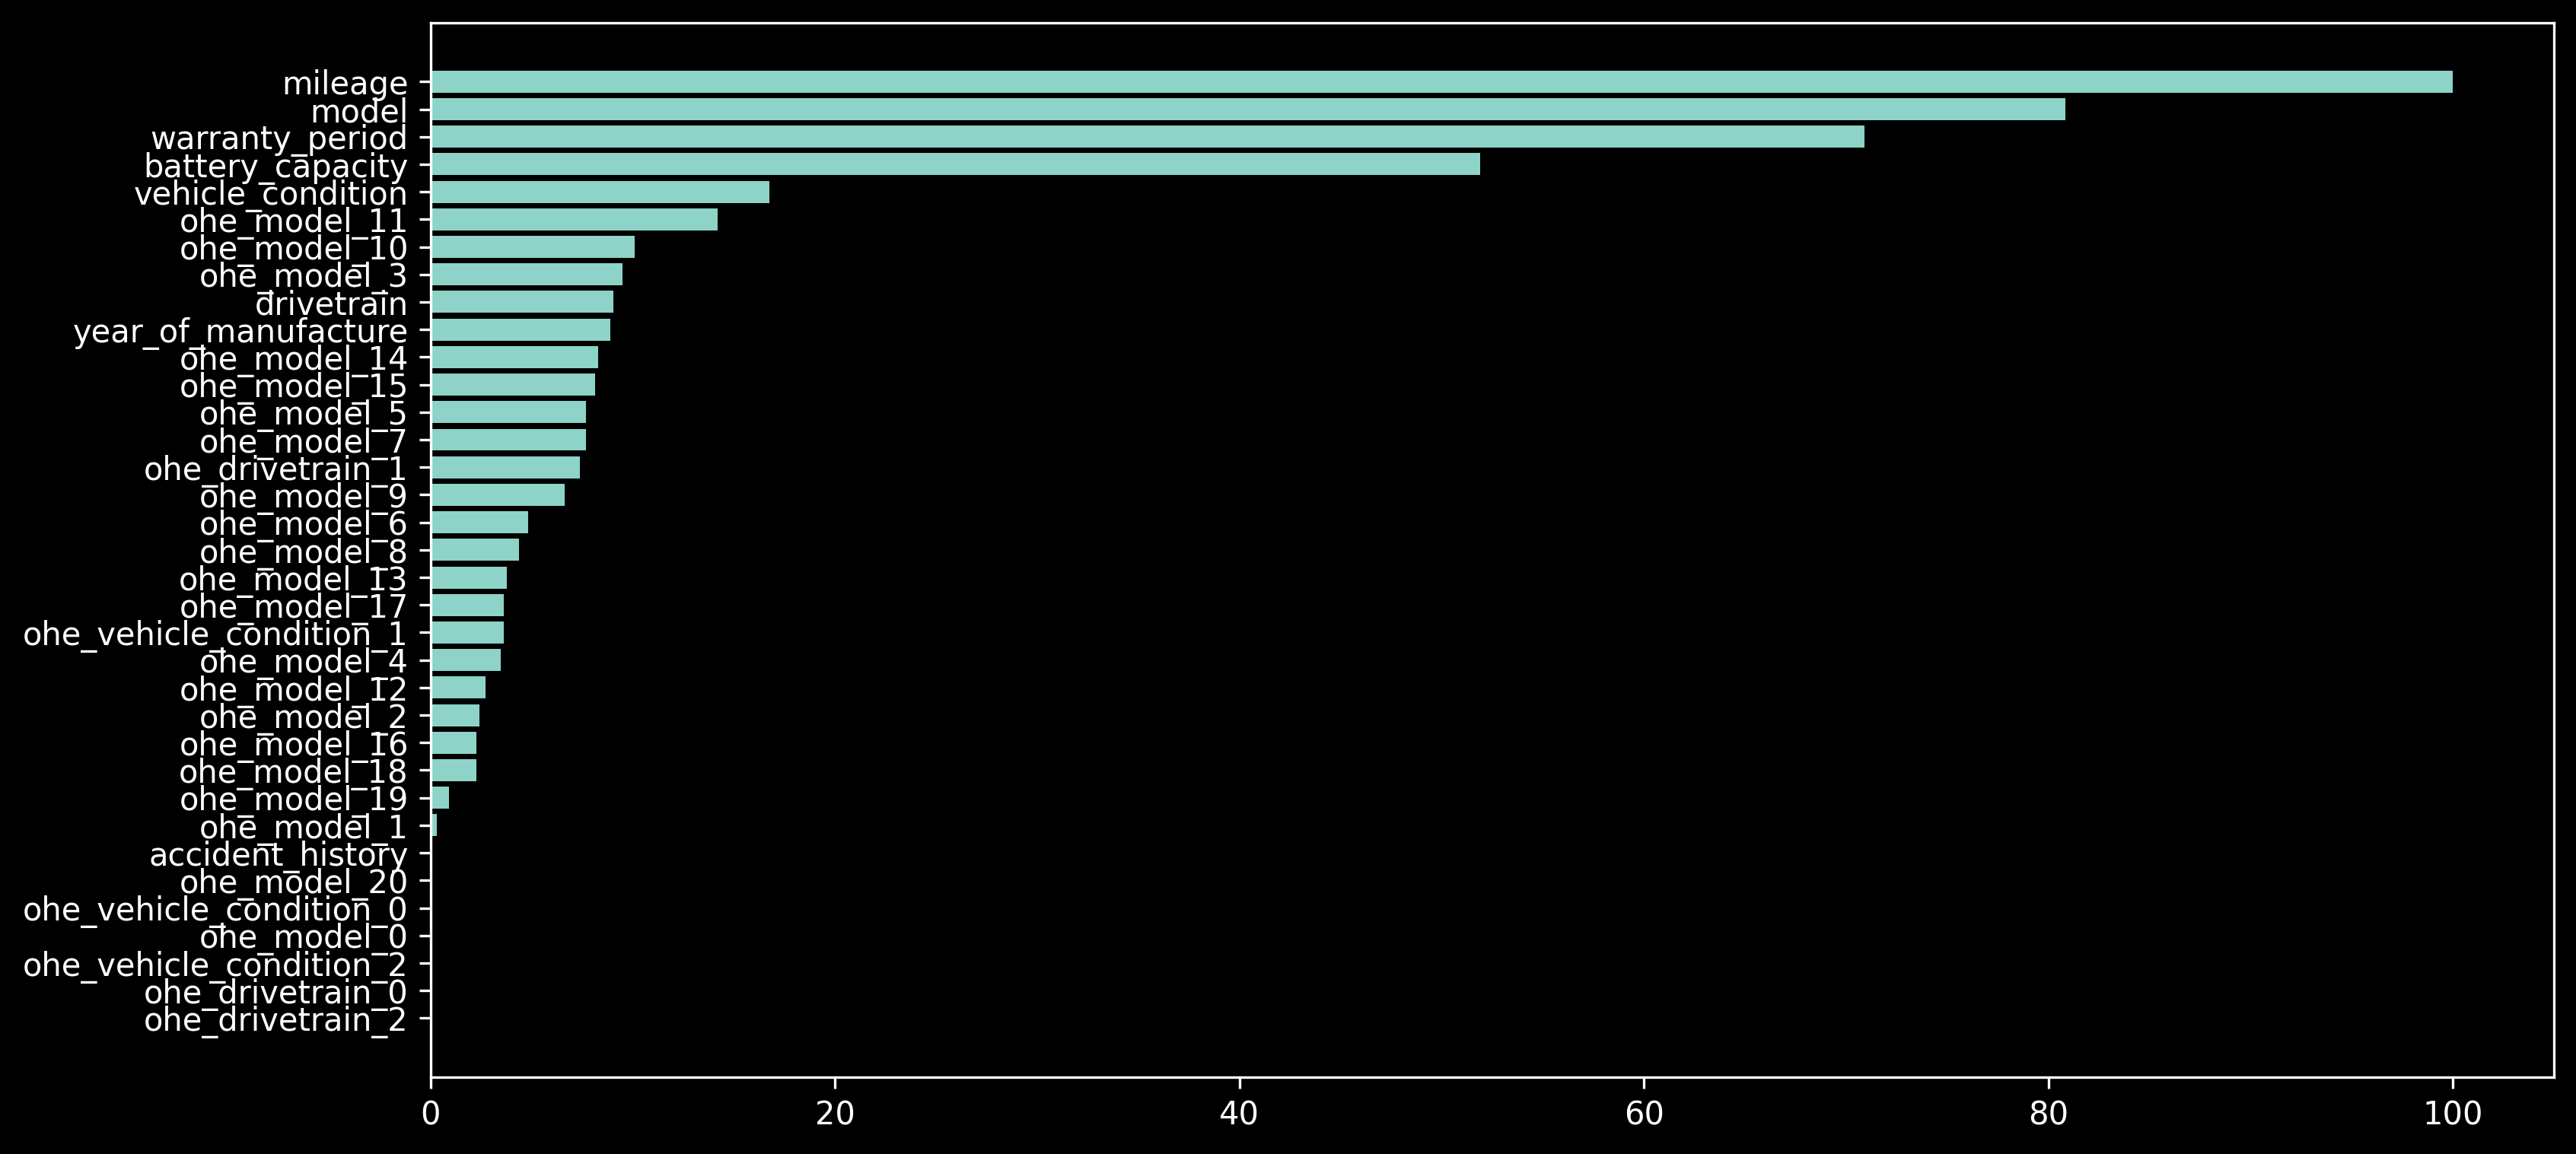

In [21]:
# visualize model.feature_importances_
feature_importance = model.feature_importances_
model.feature_name_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5   
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(model.feature_name_)[sorted_idx])
plt.show()

In [44]:
for model in models:
    l=list(zip(model.feature_name_, model.feature_importances_))

In [45]:
l

[('battery_capacity', 417),
 ('mileage', 647),
 ('ohe_vehicle_condition_0', 65),
 ('ohe_vehicle_condition_1', 27),
 ('ohe_vehicle_condition_2', 8),
 ('ohe_drivetrain_0', 81),
 ('ohe_drivetrain_1', 57),
 ('ohe_drivetrain_2', 1),
 ('ohe_accident_history_0', 0),
 ('ohe_accident_history_1', 0),
 ('ohe_warranty_period_0', 83),
 ('ohe_warranty_period_1', 12),
 ('ohe_warranty_period_2', 37),
 ('ohe_warranty_period_3', 19),
 ('ohe_warranty_period_4', 17),
 ('ohe_warranty_period_5', 19),
 ('ohe_warranty_period_6', 40),
 ('ohe_warranty_period_7', 110),
 ('ohe_warranty_period_8', 33),
 ('ohe_warranty_period_9', 53),
 ('ohe_warranty_period_10', 51),
 ('ohe_model_0', 78),
 ('ohe_model_1', 53),
 ('ohe_model_2', 47),
 ('ohe_model_3', 59),
 ('ohe_model_4', 61),
 ('ohe_model_5', 44),
 ('ohe_model_6', 52),
 ('ohe_model_7', 65),
 ('ohe_model_8', 53),
 ('ohe_model_9', 35),
 ('ohe_model_10', 65),
 ('ohe_model_11', 87),
 ('ohe_model_12', 45),
 ('ohe_model_13', 62),
 ('ohe_model_14', 82),
 ('ohe_model_15', 6

In [22]:
train = train[[fn for fi, fn in  zip(model.feature_importances_, model.feature_name_) if fi > 0]+['y']]
test = test[[fn for fi, fn in  zip(model.feature_importances_, model.feature_name_) if fi > 0]]

In [23]:
FOLD = 20
kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
oof = np.zeros(len(train))
test_preds = np.zeros(len(test))
all_score = 0
models = []
for trn_idx, val_idx in kf.split(train):
    _train = train.iloc[trn_idx].copy()
    _valid = train.iloc[val_idx].copy()

    model = LGBMRegressor(verbose=0)
    model.fit(_train.drop(columns=['y']), _train.y, 
              eval_set=(_valid.drop(columns=['y']), _valid.y)
              )
    models.append(model)
    oof[val_idx] = model.predict(_valid.drop(columns=['y']))
    test_preds += (model.predict(test[_train.drop(columns=['y']).columns]))
    score = root_mean_squared_error((_valid.y), (model.predict(_valid.drop(columns=['y']))))
    all_score += score
test_preds /= FOLD
print(all_score / FOLD)

1.3460907820665562


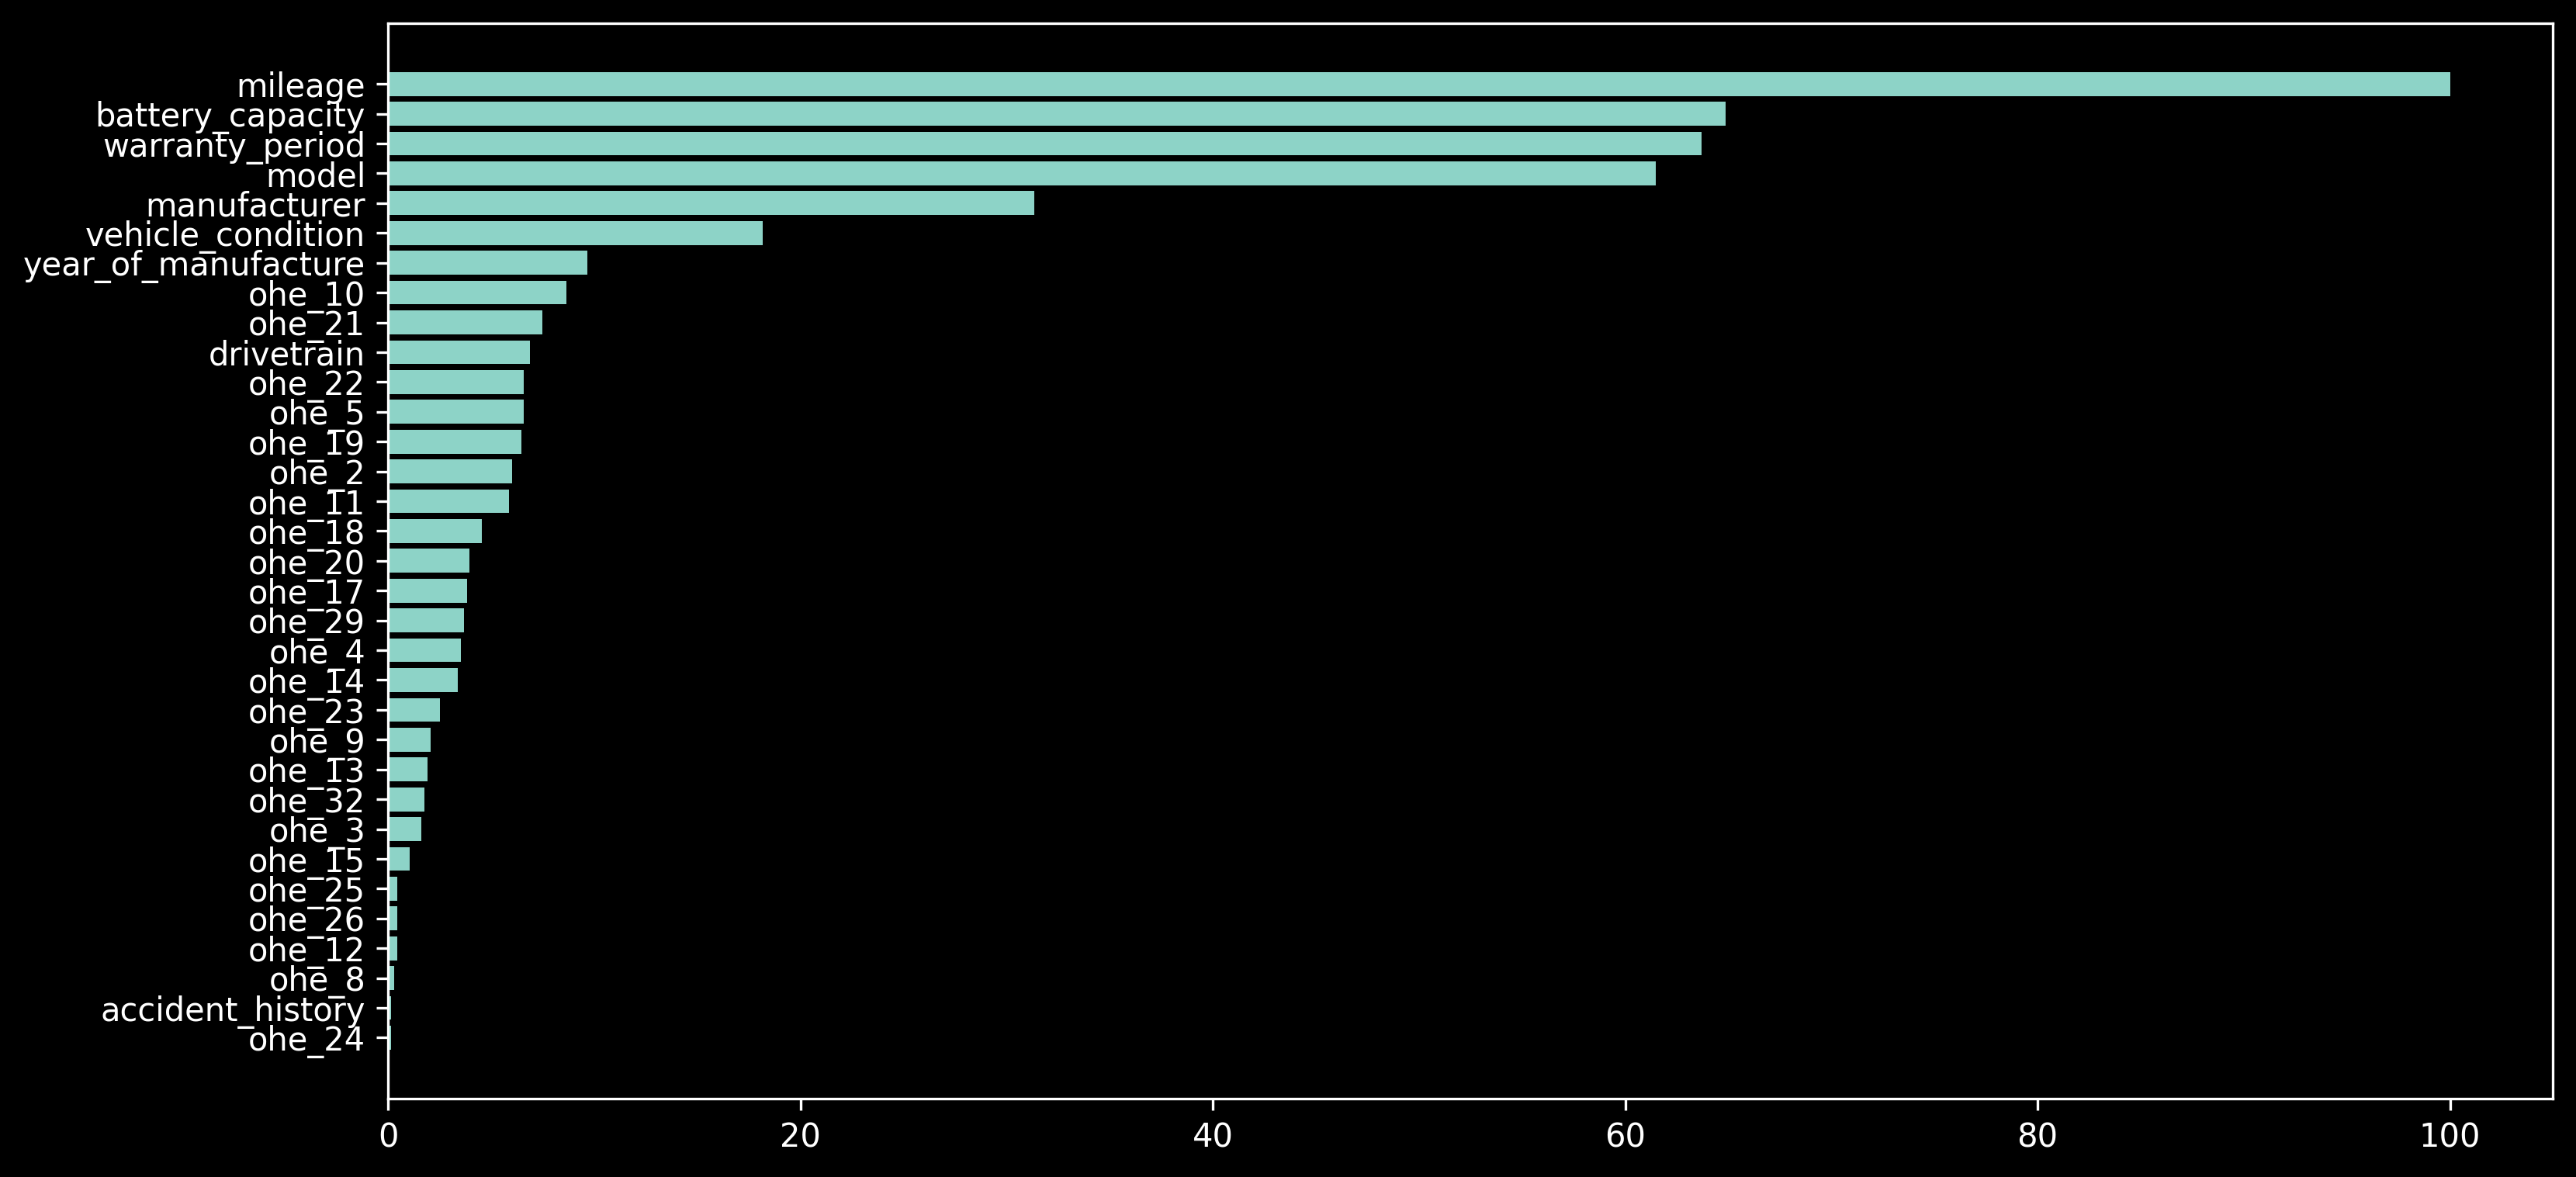

In [21]:
# visualize model.feature_importances_
feature_importance = model.feature_importances_
model.feature_name_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5   
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(model.feature_name_)[sorted_idx])
plt.show()

In [15]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['가격(백만원)'] = test_preds
submission.to_csv('submission.csv', index=False)